Colab: https://colab.research.google.com/drive/1YcMlwQgjnuP2Au-akMHnJE4dT2fqZAFE?usp=sharing

In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

In [2]:
@tf.function()
def rastrigin(x, n=2):
    # Calculate the value of Rastrigin function at a given point in space
    return 10 * n + tf.reduce_sum(tf.pow(x, 2) - 10 * tf.math.cos(2.0 * math.pi * x), axis=1, keepdims=True)


@tf.function()
def get_initial_solution(k, n=2):
    # Return random solutions
    return tf.random.uniform([k, n], minval=-5.12, maxval=5.12, dtype=tf.float32)


@tf.function()
def get_energies(k):
    # Return initial energies of agents
    return tf.zeros([k, 1], dtype=tf.float32) + 5.0


@tf.function()
def crossing(a, b, n):
    k = tf.reduce_sum(tf.ones_like(a[:, 0], dtype=tf.int32))
    
    # Random bubble (hyper-sphere) between points
    reposition = tf.random.uniform([k, n], minval=-1, maxval=1)
    reposition = reposition / tf.norm(reposition, axis=1, keepdims=True)
    new_position_1 = ((a + b) / 2.0) + (tf.maximum((tf.norm(a - b, axis=1, keepdims=True) / 2.0), 1e-3) * reposition)
    
    # Random exchange of genomes
    new_position_2 = tf.where(
        tf.random.uniform(shape=[k, 1]) < tf.random.uniform([1], 0.05, 0.95), a, b)

    # Choose one crossing or another
    new_position = tf.where(
        tf.random.uniform(shape=[k, 1]) < tf.random.uniform([1], 0.2, 0.5), new_position_1, new_position_2)

    # Apply mutation, because why not
    # Cauchy distribution derived from uniform distribution
    mutation = 0.05 * tf.math.tan(tf.random.uniform(minval=-1.0 * math.pi / 2 + 1e-6, maxval=math.pi / 2 - 1e-6, shape=[k, n]))
    new_position_m = tf.where(
        tf.random.uniform(shape=[k, 1]) < tf.random.uniform([1], 0.05, 0.4), new_position + mutation, new_position)
    
    # Choose mutated or not
    new_position = tf.where(
        tf.random.uniform(shape=[k, 1]) < 0.4, new_position_m, new_position)

    new_position = tf.clip_by_value(new_position, clip_value_min=-5.12, clip_value_max=5.12)

    return new_position


@tf.function()
def do_reproduction(reproduce_solution, reproduce_energy, n):
    # Reproduction arena
    n_pairs = tf.reduce_sum(tf.ones_like(reproduce_solution[:, 0], dtype=tf.int32)) // 2
    arena_r = 2 * n_pairs

    a = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 0, :]
    b = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 1, :]

    new_position = crossing(a, b, n)

    new_solution = tf.concat([
            reproduce_solution[:arena_r],
            new_position,
            reproduce_solution[arena_r:]],
        axis=0)
    new_energy = tf.concat([
            reproduce_energy[:arena_r] - 2.5,
            5.0 * tf.ones_like(new_position[:, :1], dtype=tf.float32),
            reproduce_energy[arena_r:]],
        axis=0)

    return new_solution, new_energy, n_pairs


@tf.function()
def do_fight(fight_solution, fight_energy, n):
    # Fighting arena
    arena_f = 2 * (tf.reduce_sum(tf.ones_like(fight_solution[:, 0], dtype=tf.int32)) // 2)
    score = rastrigin(fight_solution, n)
    best_score = tf.reduce_min(score)

    a = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 0, :]
    b = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 1, :]
    
    winner = tf.concat([a < b, a >= b], axis=1)
    prize = tf.reduce_sum(
        tf.minimum(tf.where(winner, 0.0, tf.reshape(fight_energy[:arena_f], [-1, 2])), 2.0),
        axis=1, keepdims=True)
    prize = tf.where(winner, prize, -1.0 * prize)
    prize = tf.reshape(prize, [-1, 1])

    new_energy = tf.concat([fight_energy[:arena_f] + prize, fight_energy[arena_f:]], axis=0)
    not_dead = new_energy[:, 0] > 1e-5
    new_energy = tf.boolean_mask(new_energy, not_dead)
    new_solution = tf.boolean_mask(fight_solution, not_dead)

    return new_solution, new_energy, best_score

In [3]:
def function_factory(loop_autograph, loop_xla, main_reduce_retrace, main_xla):
    @tf.function(autograph=loop_autograph, jit_compile=loop_xla)
    def while_loop_works(k, epochs, n, current_pop_size, max_pop_size, energy, solution, best_scores, pop_sizes, crossings):

        def cond(step, energy, solution, current_pop_size, best_scores, pop_sizes, crossings):
            return tf.less(step, epochs)

        def body(step, energy, solution, current_pop_size, best_scores, pop_sizes, crossings, max_pop_size=max_pop_size, k=k):
            current_pop_size = current_pop_size
            energy = energy[:current_pop_size]
            solution = solution[:current_pop_size]

            reproduce = (energy > 10)[:, 0]
            fight = tf.math.logical_not(reproduce)

            reproduce_solution, reproduce_energy, n_pairs = do_reproduction(
                tf.boolean_mask(solution, reproduce),
                tf.boolean_mask(energy, reproduce),
                n)
            fight_solution, fight_energy, best_score = do_fight(
                tf.boolean_mask(solution, fight),
                tf.boolean_mask(energy, fight),
                n)

            solution = tf.concat([reproduce_solution, fight_solution], axis=0)[:max_pop_size]
            energy = tf.concat([reproduce_energy, fight_energy], axis=0)[:max_pop_size]

            current_pop_size = tf.reduce_sum(tf.ones_like(energy, dtype=tf.int32))

            perm = (tf.cast(tf.range(current_pop_size), dtype=tf.int32) * 24179) % current_pop_size
            energy = tf.gather(energy[:current_pop_size], perm)
            solution = tf.gather(solution[:current_pop_size], perm)

            best_scores = tf.tensor_scatter_nd_update(
                best_scores, [[step]], [best_score])
            pop_sizes = tf.tensor_scatter_nd_update(
                pop_sizes, [[step]], [current_pop_size])
            crossings = tf.tensor_scatter_nd_update(
                crossings, [[step]], [n_pairs])
            
            pad_size = tf.maximum(max_pop_size - current_pop_size, 0)
            solution = tf.pad(solution, paddings=[[0, pad_size], [0, 0]], constant_values=0)
            energy = tf.pad(energy, paddings=[[0, pad_size], [0, 0]], constant_values=0)
            
            return (
                tf.add(step, 1),
                tf.reshape(energy, [k, 1]),
                tf.reshape(solution, [k, n]),
                current_pop_size,
                best_scores,
                pop_sizes,
                crossings,
            )

        _, energy, solution, current_pop_size, best_scores, pop_sizes, crossings = tf.while_loop(
            cond=cond,
            body=body,
            loop_vars=[tf.constant(0, dtype=tf.int32), energy, solution, current_pop_size, best_scores, pop_sizes, crossings],
            parallel_iterations=1,
        )

        return energy, solution, best_scores, pop_sizes, crossings


    @tf.function(reduce_retracing=main_reduce_retrace, jit_compile=main_xla)
    def emas_rastrigin(k, epochs, n, max_pop_size):
        assert k <= max_pop_size
        with tf.GradientTape() as t:
            with t.stop_recording():
                k_ = tf.constant(k, dtype=tf.int32)
                n_ = tf.constant(n, dtype=tf.int32)
                epochs = tf.constant(epochs, dtype=tf.int32)

                best_scores = tf.zeros([epochs], dtype=tf.float32) + math.nan
                pop_sizes = tf.zeros([epochs], dtype=tf.int32)
                crossings = tf.zeros([epochs], dtype=tf.int32)
                max_pop_size = tf.constant(max_pop_size, dtype=tf.int32)
                current_pop_size = k_

                energy = get_energies(k_)
                solution = get_initial_solution(k_, n_)

                energy = tf.pad(energy, paddings=[[0, max_pop_size - current_pop_size], [0, 0]], constant_values=0)
                solution = tf.pad(solution, paddings=[[0, max_pop_size - current_pop_size], [0, 0]], constant_values=0)

                energy, solution, best_scores, pop_sizes, crossings = while_loop_works(
                    k, epochs, n, current_pop_size, max_pop_size, energy, solution, best_scores, pop_sizes, crossings)
                
                return solution, energy, best_scores, pop_sizes, crossings
    
    return emas_rastrigin

# Time testing

## CPU

### Without XLA

#### Small n and k - a lot of epochs

In [134]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [135]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 14.9583s


#### Large n and k - not that many epochs

In [136]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [137]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 64.3765s


### With XLA

#### Small n and k - a lot of epochs

In [131]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [133]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 12.1042s


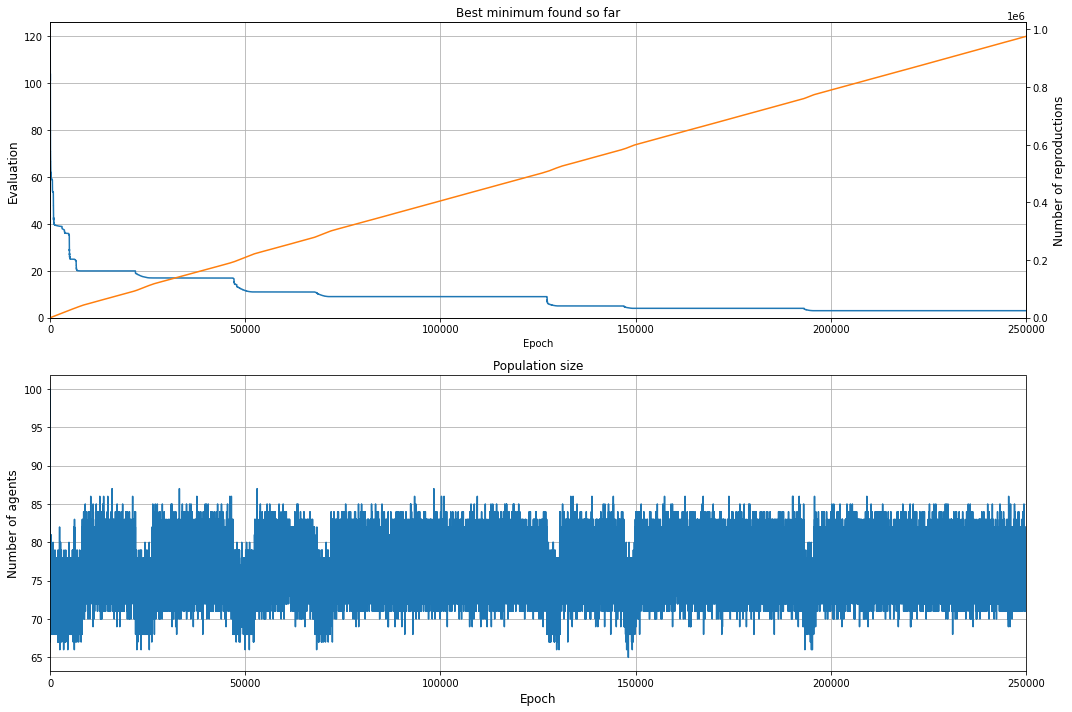

In [125]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.ylim(0)
plt.grid()
plt.twinx()
plt.ylabel("Number of reproductions", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), np.cumsum(crossings), c='tab:orange')
plt.ylim(0)

plt.subplot(2, 1, 2)
plt.title("Population size")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Number of agents", fontsize=12)
plt.plot(np.arange(1, len(pop_sizes) + 1), pop_sizes)
plt.xlim(0, len(pop_sizes) + 1)
plt.grid()

plt.tight_layout()
plt.show()

#### Large n and k - not that many epochs

In [138]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [140]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 60.5606s


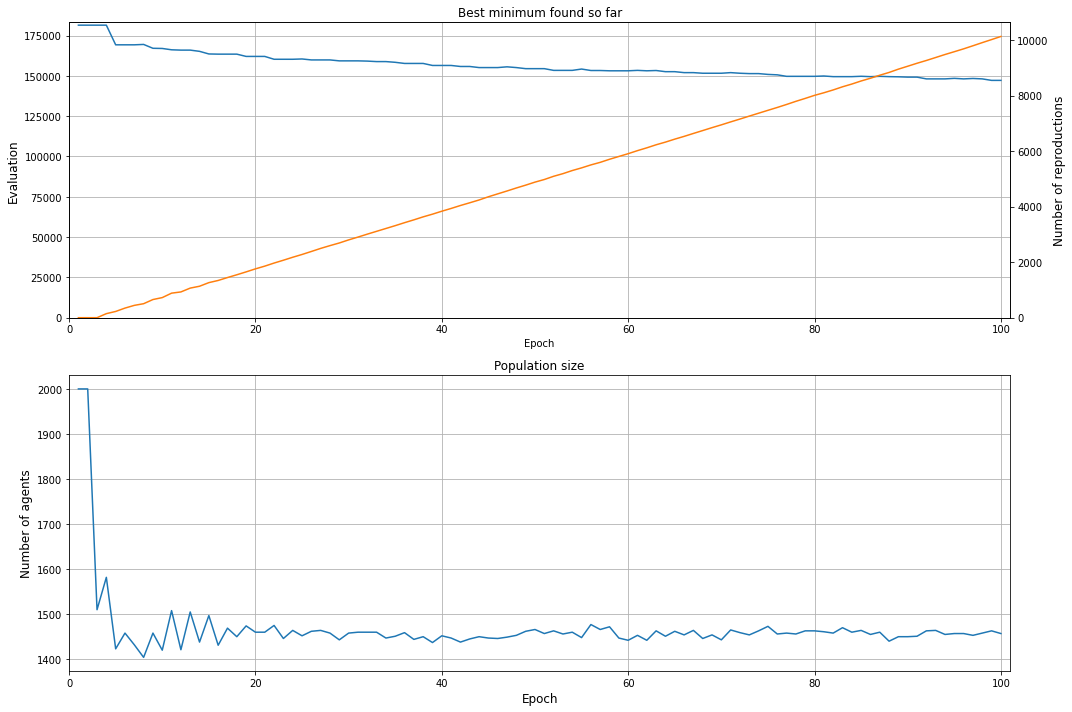

In [128]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.ylim(0)
plt.grid()
plt.twinx()
plt.ylabel("Number of reproductions", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), np.cumsum(crossings), c='tab:orange')
plt.ylim(0)

plt.subplot(2, 1, 2)
plt.title("Population size")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Number of agents", fontsize=12)
plt.plot(np.arange(1, len(pop_sizes) + 1), pop_sizes)
plt.xlim(0, len(pop_sizes) + 1)
plt.grid()

plt.tight_layout()
plt.show()

## GPU - standard

### Without XLA

#### Small n and k - a lot of epochs

In [4]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [6]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 43.2964s


#### Large n and k - not that many epochs

In [7]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [10]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 0.5612s


### With XLA

#### Small n and k - a lot of epochs

In [11]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [13]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 38.9117s


#### Large n and k - not that many epochs

In [14]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [32]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 0.4856s


## GPU - premium

### Without XLA

#### Small n and k - a lot of epochs

In [4]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [6]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 52.3314s


#### Large n and k - not that many epochs

In [7]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=False)

In [11]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 0.1559s


### With XLA

#### Small n and k - a lot of epochs

In [12]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [13]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 50.5861s


#### Large n and k - not that many epochs

In [14]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [36]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 0.1379s


#### Ultra: Large n and k - a lot of epochs

In [50]:
k = 2000
epochs = 50000
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [51]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 72.2127s


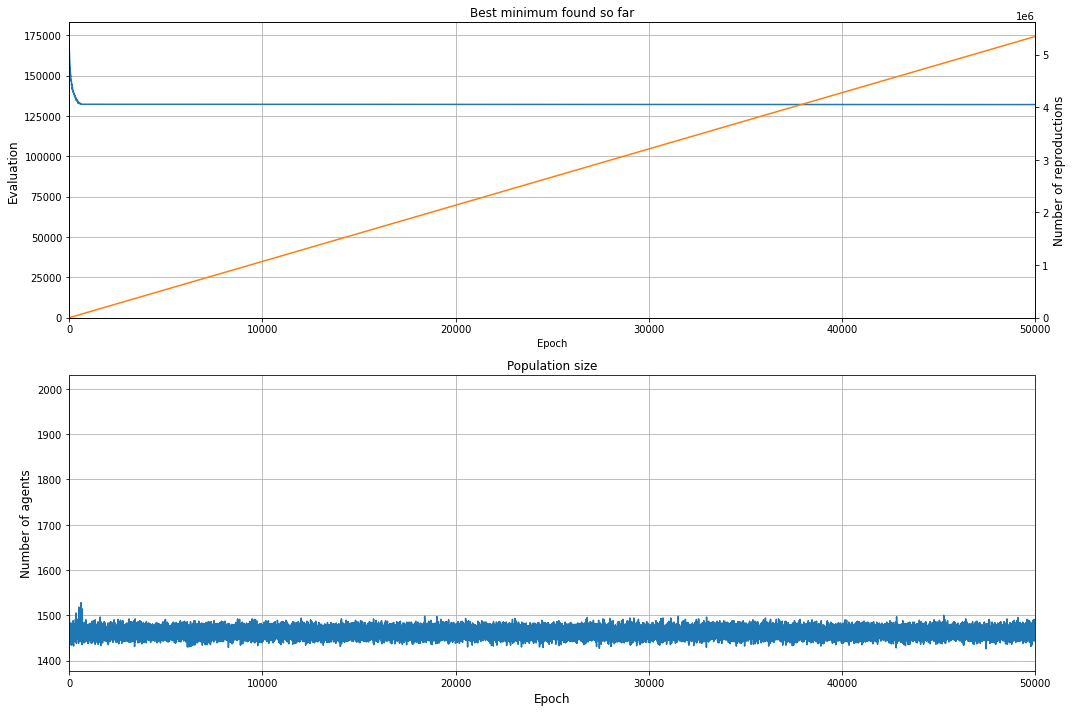

In [52]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.ylim(0)
plt.grid()
plt.twinx()
plt.ylabel("Number of reproductions", fontsize=12)
plt.plot(np.arange(1, len(best_scores) + 1), np.cumsum(crossings), c='tab:orange')
plt.ylim(0)

plt.subplot(2, 1, 2)
plt.title("Population size")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Number of agents", fontsize=12)
plt.plot(np.arange(1, len(pop_sizes) + 1), pop_sizes)
plt.xlim(0, len(pop_sizes) + 1)
plt.grid()

plt.tight_layout()
plt.show()

## TPU

### With XLA

Note: TPU devices always perform XLA compilation.

#### Small n and k - a lot of epochs

In [4]:
k = 100
epochs = 250000
n = 10

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [7]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('tpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 11.5694s


#### Large n and k - not that many epochs

In [8]:
k = 2000
epochs = 100
n = 10000

emas_rastrigin = function_factory(loop_autograph=False, loop_xla=True, main_reduce_retrace=True, main_xla=True)

In [10]:
emas_rastrigin(k=k, epochs=10, n=n, max_pop_size=k)  # Make sure graph is built
start_time = timeit.default_timer()

with tf.device('tpu:0'):
    solution, energy, best_scores, pop_sizes, crossings = emas_rastrigin(k=k, epochs=epochs, n=n, max_pop_size=k)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

assert tf.abs(tf.reduce_sum(energy) - k * 5) < 1e-4, "Energy not preserved"

Time 58.9382s
